In [7]:
from tensorflow.keras.applications import ResNet50V2, InceptionV3
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, BatchNormalization, Activation, Concatenate, DepthwiseConv2D, Multiply,
    Dropout, GlobalAveragePooling2D, Dense, MaxPooling2D, Flatten, Add, Reshape, AveragePooling2D
)
from tensorflow.keras.regularizers import l2

from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, Callback, LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
# Any additional code or custom layers you have can be added here.


In [2]:
input_shape = (224, 224, 3)

test_dir = '/root/Breast Cancer/Datasets/40XResized/test'
train_dir = '/root/Breast Cancer/Datasets/40XResized/train'


batch_size = 32
num_classes = 2
# filter_factor = 8

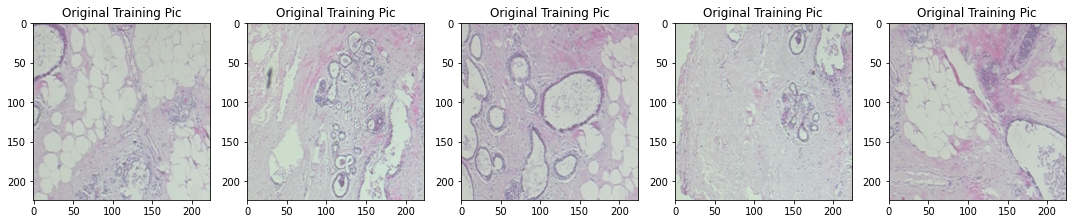

In [3]:
train_BC = '/root/Breast Cancer/Datasets/40XResized/train/benign'

#Show the import original image
train_img_files = os.listdir(train_BC)
# test_img_files = os.listdir(test_dir)
# val_img_files = os.listdir(val_dir)

show_num = 5

plt.figure(figsize = (15, 5))

for i in range(show_num):
    
    img_path = os.path.join(train_BC, train_img_files[i])
    img = plt.imread(img_path)
    plt.subplot(1, show_num, i + 1)
    plt.imshow(img)
    plt.axis('on')
    plt.title("Original Training Pic")
    
plt.tight_layout()
plt.show()


In [4]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.13,  # Specify the validation split here
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1.0/255)

# Load and preprocess the training and testing images
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'  # Use 'training' subset for training data
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'  # Use 'validation' subset for validation data
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical'
)


Found 2264 images belonging to 2 classes.
Found 338 images belonging to 2 classes.
Found 304 images belonging to 2 classes.


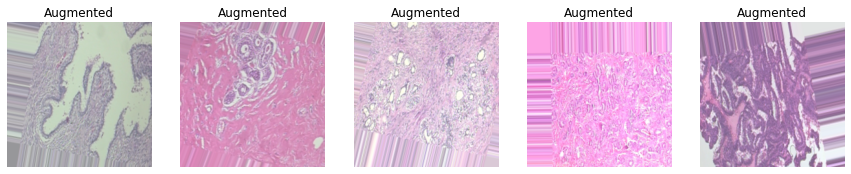

In [5]:
#To show the augmented pictures, after rotation, zoom in, rescale etc

# import scipy

# Extract a batch of images from the train_generator
sample_images, sample_labels = next(train_generator)

plt.figure(figsize = (15, 5))

# Show the original images from the batch
num_images_to_show = 5  # Show three images
for i in range(num_images_to_show):
    plt.subplot(1, num_images_to_show, i + 1)
    plt.imshow(sample_images[i-1])
    plt.title("Augmented")
    plt.axis('off')

In [8]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)

2024-03-24 21:11:45.011681: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-24 21:11:45.705458: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22134 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:99:00.0, compute capability: 8.9


87910968/87910968 [==============================] - 6s 0us/step


In [9]:
# 冻结基础模型的所有层，这样它们在训练过程中不会被更新
for layer in base_model.layers:
    layer.trainable = False

In [10]:
# 添加自定义层
x = base_model.output
x = GlobalAveragePooling2D()(x)  # 添加全局平均池化层
x = Dense(512, activation='relu')(x)  # 添加一个全连接层
# 根据您的任务添加最后一层，这里是二分类任务
predictions = Dense(num_classes, activation='softmax')(x)

In [11]:
model = Model(inputs=base_model.input, outputs=predictions)

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [14]:
lr = 0.001
Optimizer = Adam(learning_rate = lr)

from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow_addons.metrics import F1Score
from tensorflow.keras import backend as K


model.compile(
    optimizer='adam',
    loss = "categorical_crossentropy",
    metrics=[
        "accuracy", 
        Precision(), 
        Recall(), 
        AUC(),
        F1Score(num_classes=2, average = 'micro')
    ]
)

MODEL_NAME = "InceptionV3"  # 用您的模型名替换
# 训练合并后的模型
csv_logger = tf.keras.callbacks.CSVLogger(
    fr"/root/Breast Cancer/CSVHistory/{MODEL_NAME}.csv", 
    separator=",", 
    append=False)


lr_reduction = ReduceLROnPlateau(monitor = 'val_loss', 
                                 factor = 0.1,
                                patience = 10,
                                min_lr = 0.00001,
                                verbose = 1)

# f1_score_callback = F1ScoreCallback(train_generator = train_generator, 
#                                     validation_generator=validation_generator, 
#                                     num_classes=num_classes)


from tensorflow.keras.callbacks import ModelCheckpoint

# 设置模型保存路径
model_checkpoint_path = "/root/Breast Cancer/Model Code/ModelFileH5/InceptionV3.h5"

# 创建ModelCheckpoint回调，保存最佳模型
model_checkpoint_callback = ModelCheckpoint(
    filepath=model_checkpoint_path,
    save_best_only=True,  # 仅保存在验证集上性能最好的模型
    monitor='val_loss',  # 监控的指标
    mode='min',  # 'min'意味着监控指标的最小值，'val_loss'减小意味着性能改善
    verbose=1  # 日志级别
)




In [15]:
history = model.fit(
    train_generator,
    epochs=150,  # 根据需要调整epochs数
    validation_data=validation_generator,
    callbacks=[csv_logger, lr_reduction, model_checkpoint_callback]  # 确保这里添加了model_checkpoint_callback
)


# history = DIR.fit(
#     train_generator,
#     epochs=150,
#     validation_data=validation_generator,
#     callbacks=[csv_logger, lr_reduction, model_checkpoint_callback, f1_score_callback]
# )


Epoch 1/150


2024-03-24 21:40:06.354018: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2024-03-24 21:40:07.368174: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2024-03-24 21:40:07.368197: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2024-03-24 21:40:07.368262: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


 2/71 [..............................] - ETA: 4s - loss: 2.8995 - accuracy: 0.5156 - precision_1: 0.5156 - recall_1: 0.5156 - auc_1: 0.6045 - f1_score: 0.5156  

2024-03-24 21:40:08.366570: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


71/71 [==============================] - ETA: 0s - loss: 0.7805 - accuracy: 0.7023 - precision_1: 0.7023 - recall_1: 0.7023 - auc_1: 0.7436 - f1_score: 0.7023
Epoch 1: val_loss improved from inf to 0.53326, saving model to /root/Breast Cancer/Model Code/ModelFileH5/InceptionV3.h5
71/71 [==============================] - 45s 524ms/step - loss: 0.7805 - accuracy: 0.7023 - precision_1: 0.7023 - recall_1: 0.7023 - auc_1: 0.7436 - f1_score: 0.7023 - val_loss: 0.5333 - val_accuracy: 0.7249 - val_precision_1: 0.7249 - val_recall_1: 0.7249 - val_auc_1: 0.8126 - val_f1_score: 0.7249 - lr: 0.0010
Epoch 2/150
71/71 [==============================] - ETA: 0s - loss: 0.4871 - accuracy: 0.7681 - precision_1: 0.7681 - recall_1: 0.7681 - auc_1: 0.8483 - f1_score: 0.7681
Epoch 2: val_loss improved from 0.53326 to 0.50898, saving model to /root/Breast Cancer/Model Code/ModelFileH5/InceptionV3.h5
71/71 [==============================] - 33s 468ms/step - loss: 0.4871 - accuracy: 0.7681 - precision_1: 0.76

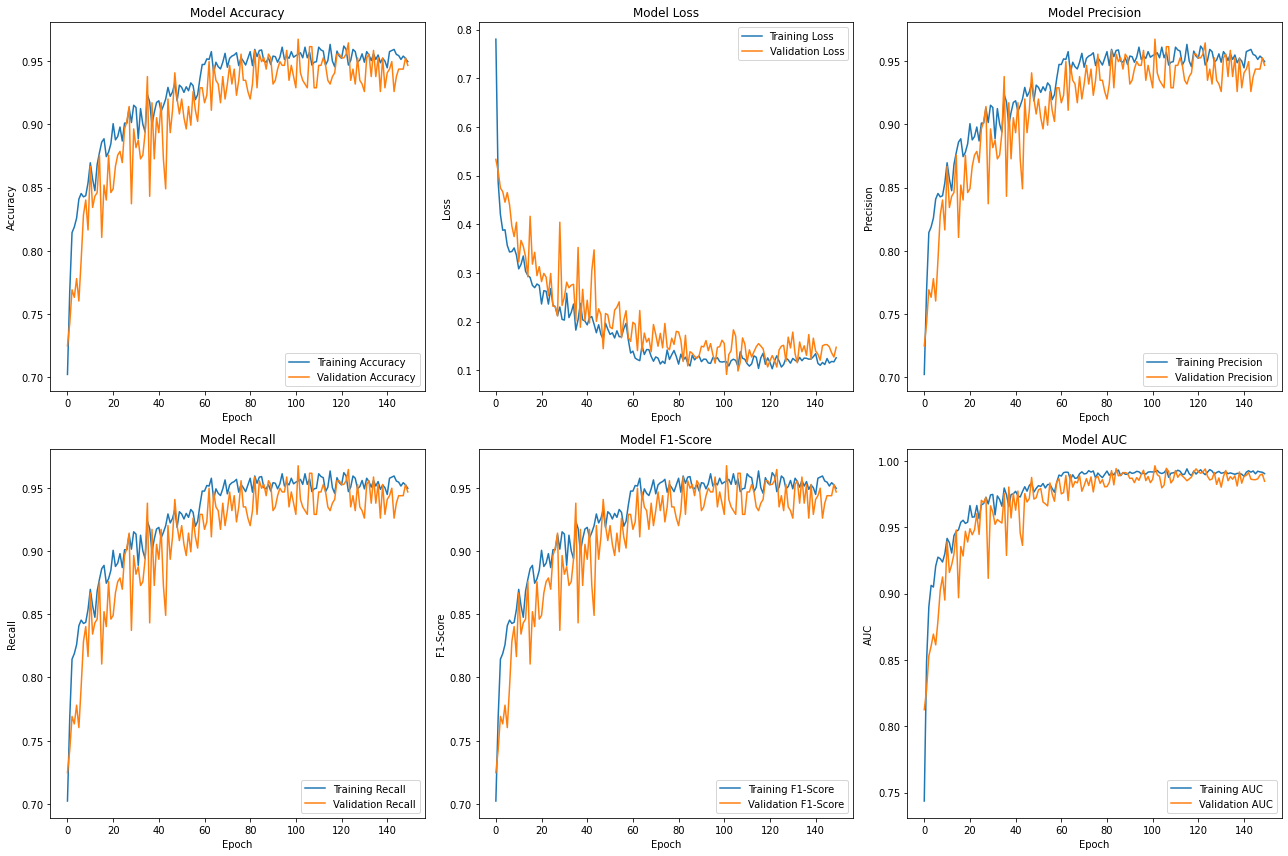

In [18]:
plt.figure(figsize=(18, 12))

plt.subplot(2, 3, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')

plt.subplot(2, 3, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')

plt.subplot(2, 3, 3)
plt.plot(history.history['precision_1'])
plt.plot(history.history['val_precision_1'])
plt.title('Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend(['Training Precision', 'Validation Precision'], loc='lower right')


plt.subplot(2, 3, 4)
plt.plot(history.history['recall_1'])
plt.plot(history.history['val_recall_1'])
plt.title('Model Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend(['Training Recall', 'Validation Recall'], loc='lower right')

plt.subplot(2, 3, 5)
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])
plt.title('Model F1-Score')
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.legend(['Training F1-Score', 'Validation F1-Score'], loc='lower right')

# plt.subplot(2, 3, 5)
# plt.plot(range(1, len(f1_score_callback.train_f1_scores) + 1), f1_score_callback.train_f1_scores, label='Training F1 Score')
# plt.plot(range(1, len(f1_score_callback.val_f1_scores) + 1), f1_score_callback.val_f1_scores, label='Validation F1 Score')
# plt.title('Model F1-Score')
# plt.xlabel('Epoch')
# plt.ylabel('F1-Score')
# plt.legend(['F1 Score'], loc='lower right')


plt.subplot(2, 3, 6)
plt.plot(history.history['auc_1'])
plt.plot(history.history['val_auc_1'])
plt.title('Model AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend(['Training AUC', 'Validation AUC'], loc='lower right')

plt.tight_layout()
plt.show()

9/9 [==============================] - 2s 30ms/step


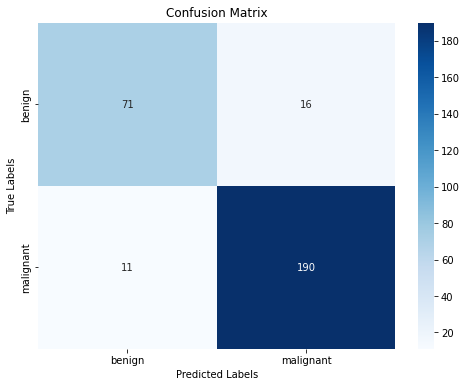

In [19]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 收集图像和真实标签
all_images, all_true_labels = zip(*[next(test_generator) for _ in range(test_generator.samples // test_generator.batch_size)])
all_images = np.concatenate(all_images)
all_true_labels = np.argmax(np.concatenate(all_true_labels), axis=1)

# 进行预测并获取预测标签
predictions = model.predict(all_images)
predicted_labels = np.argmax(predictions, axis=1)

# 生成并绘制混淆矩阵
conf_matrix = confusion_matrix(all_true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["benign", "malignant"], yticklabels=["benign", "malignant"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


In [20]:
from sklearn.metrics import f1_score


# 计算F1-Score
f1 = f1_score(all_true_labels, predicted_labels, average='macro')

print("F1-Score:", f1)


f1_each_class = f1_score(all_true_labels, predicted_labels, average=None)
print("F1-Score for each class:", f1_each_class)


F1-Score: 0.8869488100257331
F1-Score for each class: [0.84023669 0.93366093]


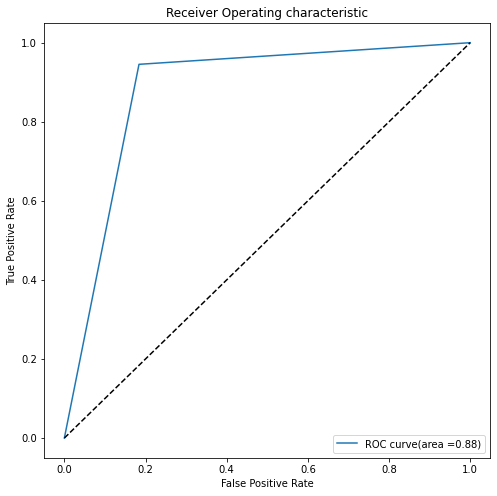

In [21]:
#compute precision-recall score
from sklearn.metrics import roc_curve, auc

#compute precision, recall(sensitivity), and threshold values
fpr, tpr, thresholds = roc_curve(all_true_labels, predicted_labels)

#compute the AUC score
roc_auc= auc(fpr, tpr)

#plot the precision-recall curve
plt.figure(figsize=(8,8))
plt.plot(fpr, tpr, label= 'ROC curve(area =%0.2f)' %roc_auc)
plt.plot([0, 1], [0,1], 'k--')
plt.title('Receiver Operating characteristic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [22]:
#compute sensitivity and specificity
sensitivity=tpr[1] #True positive rate 
specificity= 1-fpr[1]

print('sensitivity:', sensitivity)
print('specificity:', specificity)

sensitivity: 0.945273631840796
specificity: 0.8160919540229885


9/9 [==============================] - 0s 27ms/step


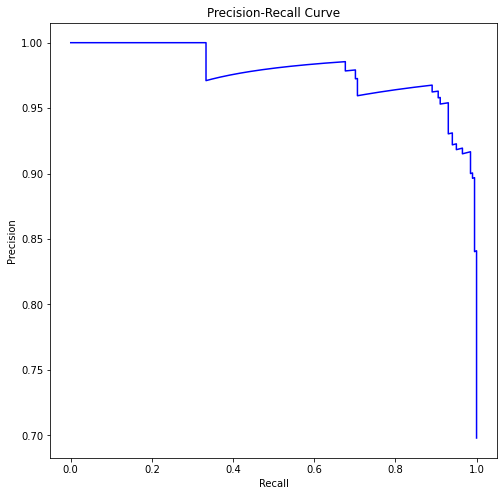

In [23]:
from sklearn.metrics import precision_recall_curve

# 计算预测概率
ensemble_pred_probs =  model.predict(all_images)

# 获取预测正类的概率
# 假设是二分类问题，并且正类是第二个类别
positive_class_probs = ensemble_pred_probs[:, 1]

# 计算 Precision 和 Recall
precision, recall, thresholds = precision_recall_curve(all_true_labels, positive_class_probs)

plt.figure(figsize=(8, 8))
plt.plot(recall, precision, color='b')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

In [24]:
test_loss, test_acc, test_precision, test_recall, test_auc, test_f1_score = model.evaluate(test_generator)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)
print('Test precision:', test_precision)
print('Test recall:', test_recall)
print('Test AUC:', test_auc)
print('Test F1 Score:', test_f1_score)

# test_loss, test_acc, test_precision, test_recall, test_auc = DIR.evaluate(test_generator)
# print('Test loss:', test_loss)
# print('Test accuracy:', test_acc)
# print('Test precision:', test_precision)
# print('Test recall:', test_recall)
# print('Test AUC:', test_auc)


# from sklearn.metrics import f1_score
# import numpy as np

# # 预测测试集
# y_pred = DIR.predict(test_generator)
# y_pred = np.argmax(y_pred, axis=1)

# # 真实标签
# y_true = test_generator.classes

# # 计算F1分数
# test_f1_score = f1_score(y_true, y_pred, average='micro')  # 或者根据你的需要选择其他average参数
# print('Test F1 Score:', test_f1_score)


10/10 [==============================] - 2s 143ms/step - loss: 0.2303 - accuracy: 0.9046 - precision_1: 0.9046 - recall_1: 0.9046 - auc_1: 0.9695 - f1_score: 0.9046
Test loss: 0.23026438057422638
Test accuracy: 0.9046052694320679
Test precision: 0.9046052694320679
Test recall: 0.9046052694320679
Test AUC: 0.9694804549217224
Test F1 Score: 0.9046052694320679


In [25]:
from sklearn.metrics import classification_report

# 使用模型对验证集进行预测，获取预测概率
y_pred_probs = model.predict(all_images)

# 将预测概率转换为类别标签
y_pred_labels = np.argmax(y_pred_probs, axis=1)

# 假设 y_val 是真实标签，并且也是类别标签形式
# 现在您可以生成分类报告
report = classification_report(all_true_labels, y_pred_labels)
print(report)


9/9 [==============================] - 0s 27ms/step
              precision    recall  f1-score   support

           0       0.87      0.82      0.84        87
           1       0.92      0.95      0.93       201

    accuracy                           0.91       288
   macro avg       0.89      0.88      0.89       288
weighted avg       0.91      0.91      0.91       288



In [26]:
#delete the model to prevent memory costs

from keras import backend as K
import gc

K.clear_session()
gc.collect()

# del DIR


from numba import cuda

cuda.select_device(0)
cuda.close()